In [1]:
from qdev_wrappers.fitting.base import Fitter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.fftpack as fftpack

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '


## What is a Fitter?
It's an instrument that can perform fits for you. It includes
- **fit_parameters channel** for parameters which are learned by performing the fit
- **success** parameter to indicate if the fit was successful (0 or 1)
- **fit function** which given data should perfom the fit and (minimally) update the fit_parameters and success
- **metadata dictionary** about the fitter with keys (minimally) 'method', 'name', 'function', and 'fit_parameters'. 'method' and 'name' should have string values, 'fit_parameters' is a list of the names of the fit_parameters and 'function' is a dictionary with (minimally) 'str' which should have a string value describing the fit function

On initialisation it requires a name, fit_parameter specifications in a dictionary and function metadata dictionary

### Example...
...of writing your own fitter

In [2]:
class SimpleMinimumFitter(Fitter):
    def __init__(self, name='SimpleMinimumFitter'):
        fit_parameters = {'location': {'label': 'location of minimum'},
                          'value': {'label': 'minimum value'}}
        function_metadata = {'str': 'find minimum (simple)'}
        super().__init__(name, fit_parameters, method='SimpleMinimum',
                         function=function_metadata)

    def fit(self, measured_values, experiment_values):
        self._check_fit(measured_values, experiment_values)
        min_index = np.argmin(measured_values)
        self.fit_parameters.location._save_val(experiment_values[min_index])
        self.fit_parameters.value._save_val(measured_values[min_index])
        self.success._save_val(1)

In [3]:
simple_minimum_fitter = SimpleMinimumFitter()

Check it has the fit_parameter channel with the specified parameters on it and a success parameter initialised in 0

In [4]:
print('fit_parameters: ', list(simple_minimum_fitter.fit_parameters.parameters.keys()))
print('success = ', simple_minimum_fitter.success())

fit_parameters:  ['location', 'value']
success =  0


Try finding the minimum of some 'data'

In [5]:
data = np.array([10, 9, 8, 3, 6, 3, 2, 1, 3, 4, 6, 7, 8])
x = np.arange(len(data))
simple_minimum_fitter.fit(data, x)
print('\n'.join(f'{k}: {v()}' for k, v in simple_minimum_fitter.fit_parameters.parameters.items()))
print('\nsuccess: ', simple_minimum_fitter.success())

location: 7
value: 1

success:  1


Text(0, 0.5, 'some measured value')

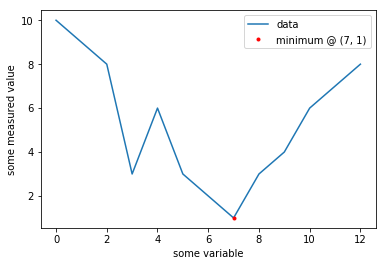

In [6]:
fig = plt.figure()
plt.plot(x, data, label='data')
x = simple_minimum_fitter.fit_parameters.location()
y = simple_minimum_fitter.fit_parameters.value()
plt.plot(x, y, 'r.', label=f'minimum @ ({x}, {y})')
plt.legend()
plt.xlabel('some variable')
plt.ylabel('some measured value')

Handily this fitter is already in the module so you can just import it as below for the same effect :)

In [7]:
from qdev_wrappers.fitting.fitters import SimpleMinimumFitter

## Least Squares fitting

If we want to do a least squares fit it gets a little bit more complicated so we wrote a subclass which has the additional features:
- **variance_parameters channel** to store the variance on each fit parameter
- **initial_value_parameters channel** to store the initial values used in the least squares optimization
- **evaluate function** function to be fit to. This will just evaluate the metadata['function']['np'] string with the fit parameters and experiment parameter input
- optionally a **guess function** to generate the initial_values for the least squares fit if none provided
- the addition of variance_parameters, initial_value_parameters, and the 'np' description of the function to the **metadata**

You need again need subclass this, specifying the fit parameters (as before) and function metadata. Note that the  'np' function metadata string is evaluated and optimised over so it must be runnable once all the fit_parameters and 'x' are specified. The order of the fit_parameters must match the order of appearance of the parameters in this funciton.

### Example

In [8]:
from qdev_wrappers.fitting.base import LeastSquaresFitter

class CosineFitter(LeastSquaresFitter):
    def __init__(self, name='CosineFitter'):
        fit_parameters = {'a': {'label': '$a$'},
                          'w': {'label': r'$\omega$', 'unit': 'Hz'},
                          'p': {'label': r'$\phi$'},
                          'c': {'label': '$c$', 'unit': ''}}
        function_metadata = {'str': r'$f(x) = a\cos(\omega x + \phi)+c$',
                             'np': 'a * np.cos(w * x + p) + c'}
        super().__init__(name, fit_parameters, function_metadata)

In [9]:
cosine_fitter = CosineFitter()

Again check out the channels and parameters

In [10]:
print('fit_parameters: ', list(cosine_fitter.fit_parameters.parameters.keys()))
print('variance_parameters: ', list(cosine_fitter.variance_parameters.parameters.keys()))
print('initial_value_parameters: ', list(cosine_fitter.initial_value_parameters.parameters.keys()))
print('success = ', cosine_fitter.success())

fit_parameters:  ['a', 'w', 'p', 'c']
variance_parameters:  ['a_variance', 'w_variance', 'p_variance', 'c_variance']
initial_value_parameters:  ['a_initial_value', 'w_initial_value', 'p_initial_value', 'c_initial_value']
success =  0


Try finding parameter values of some 'data'

In [11]:
a, w, p, c = 1., 0.5, np.pi/4, 0.3
x = np.arange(30)
data = a * np.cos(w * x + p) + c + (np.random.random(len(x)) - 0.5) / 3

In [12]:
cosine_fitter.fit(data, x, initial_values=(1, 0.4, np.pi/2, 0.1))
print('actual_values:')
print(f'a: {a:.3}\nw: {w:.3}\np: {p:.3}\nc: {c:.3}\n')
print('fit_values:')
print('\n'.join(f'{k}: {v():.3}' for k, v in cosine_fitter.fit_parameters.parameters.items()))
print('\nfit_variances:')
print('\n'.join(f'{k}: {v():.3}' for k, v in cosine_fitter.variance_parameters.parameters.items()))
print('\nsuccess: ', cosine_fitter.success())

actual_values:
a: 1.0
w: 0.5
p: 0.785
c: 0.3

fit_values:
a: 0.985
w: 0.502
p: 0.738
c: 0.288

fit_variances:
a_variance: 0.000817
w_variance: 9.86e-06
p_variance: 0.00278
c_variance: 0.000401

success:  1


Text(0, 0.5, 'some measured value')

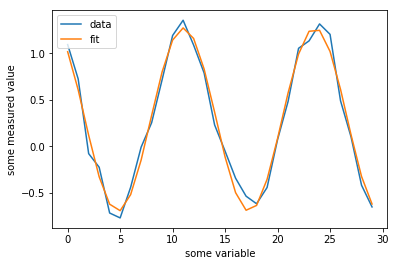

In [13]:
fig = plt.figure()
plt.plot(x, data, label='data')
fit_values = [v() for v in cosine_fitter.fit_parameters.parameters.values()]
plt.plot(x, cosine_fitter.evaluate(x, *fit_values), label='fit')
plt.legend()
plt.xlabel('some variable')
plt.ylabel('some measured value')

Note that I could equally have generated the pretend data by using the 'evaluate' function on the cosine fitter and adding noise to it.

#### Fit failure
As you can see I used the initial_values kwarg to provide a guess for the fitter (if None provided then all will be 1). If I make my guess a lot worse the fit will be much worse. The fit is still called a 'success' unless the least-squares minimization fails. However looking at the variance parameters tells us it's not very good! Have a play with the initial_values and see if you can get it to fail. It is possible to condition the fit success on whether any of the variances are infinite using the variance_limited kwarg.

If the fit fails the fit_values and variance values are stored as nan

In [14]:
initial_values = (1e10, 1e4, 1e7, 1e10)

cosine_fitter.fit(data, x, initial_values=initial_values, variance_limited=True)
print('actual_values:')
print(f'a: {a:.3}\nw: {w:.3}\np: {p:.3}\nc: {c:.3}\n')
print('fit_values:')
print('\n'.join(f'{k}: {v():.3}' for k, v in cosine_fitter.fit_parameters.parameters.items()))
print('\nstandard deviation:')
print('\n'.join(
    f'{k.split("_")[0]}: {np.sqrt(v()):.3}' for k, v in cosine_fitter.variance_parameters.parameters.items()))
print('\nsuccess: ', cosine_fitter.success())

actual_values:
a: 1.0
w: 0.5
p: 0.785
c: 0.3

fit_values:
a: -0.0177
w: 1e+04
p: 1e+07
c: 0.266

standard deviation:
a: 0.196
w: 0.000643
p: 0.0117
c: 0.135

success:  1


It is also possible to limit based on the r^{2} value which measures the distance of the fit from the estimate and is 1 if the fit matches the data exactly and is < 1 otherwise. Try playing with the r2 limit to make the fit fail

In [15]:
r2_limit = 0.99

cosine_fitter.fit(data, x, initial_values=(1, 0.4, np.pi/2, 0.1), r2_limit=r2_limit)
print('actual_values:')
print(f'a: {a:.3}\nw: {w:.3}\np: {p:.3}\nc: {c:.3}\n')
print('fit_values:')
print('\n'.join(f'{k}: {v():.3}' for k, v in cosine_fitter.fit_parameters.parameters.items()))
print('\nstandard deviation:')
print('\n'.join(
    f'{k.split("_")[0]}: {np.sqrt(v()):.3}' for k, v in cosine_fitter.variance_parameters.parameters.items()))
print('\nsuccess: ', cosine_fitter.success())

actual_values:
a: 1.0
w: 0.5
p: 0.785
c: 0.3

fit_values:
a: nan
w: nan
p: nan
c: nan

standard deviation:
a: nan
w: nan
p: nan
c: nan

success:  0


/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/fitting/base.py:170: UserWarning: Fit failed due to: r2 0.98 exceeds limit 0.99
  warnings.warn('Fit failed due to: ' + message)


#### Adding a guess function
Instead of always having to provide initial_values or hoping that 1s are good enough I can use a function to give good initial guesses. Adding this to the fitter means that if I don't provide initial_values this function will be used to generate initial values.

In [16]:
cosine_fitter.fit(data, x)
print('\n'.join(f'{k}: {v():.3}' for k, v in cosine_fitter.initial_value_parameters.parameters.items()))

a_initial_value: 1.0
w_initial_value: 1.0
p_initial_value: 1.0
c_initial_value: 1.0


In [17]:
def guess_cosine(y, x):
    """Guess for y = a * cos(wx + p) + c"""
    c = y.mean()
    a = (y.max() - y.min()) / 2
    # Get initial guess for frequency from a fourier transform
    yhat = fftpack.rfft(y - y.mean())
    idx = (yhat ** 2).argmax()
    freqs = fftpack.rfftfreq(len(x), d=(x[1] - x[0]) / (2 * np.pi))
    w = freqs[idx]
    if (y[0] - c) / a > 1:
        p = 0
    elif (y[0] - c) / a < -1:
        p = np.pi
    else:
        p = np.arccos((y[0] - c) / a)
    return [a, w, p, c]

cosine_fitter.guess = guess_cosine

In [18]:
cosine_fitter.fit(data, x)
print('\n'.join(f'{k}: {v():.3}' for k, v in cosine_fitter.initial_value_parameters.parameters.items()))

a_initial_value: 1.06
w_initial_value: 0.419
p_initial_value: 0.679
c_initial_value: 0.267


Again you will be pleased to hear that a selection of fitters and a library of guess functions already exist in qdev_wrappers.fitting.fitters and qdev_wrappers.fitting.guess respectively so I can just import the CosineFitter (which uses the guess function above) from there. Also there:
- T1Fitter
- BenchmarkingFitter
- CosineFitter
- DecayingRabisFitter

Feel free to add more if you make up some useful ones :)

In [19]:
from qdev_wrappers.fitting.fitters import CosineFitter